In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data = pd.read_csv(url, names=column_names, na_values='?')

# Handle missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=column_names)

# Define features and target variable
X = data_imputed.drop('target', axis=1)
y = data_imputed['target']

# Convert target variable to binary (1: heart disease, 0: no heart disease)
y = np.where(y > 0, 1, 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Randomized search
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_

# Train the best model
best_rf.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=400, random_state=42)

Accuracy: 0.8852
Confusion Matrix:
[[26  3]
 [ 4 28]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61

ROC-AUC Score: 0.9450


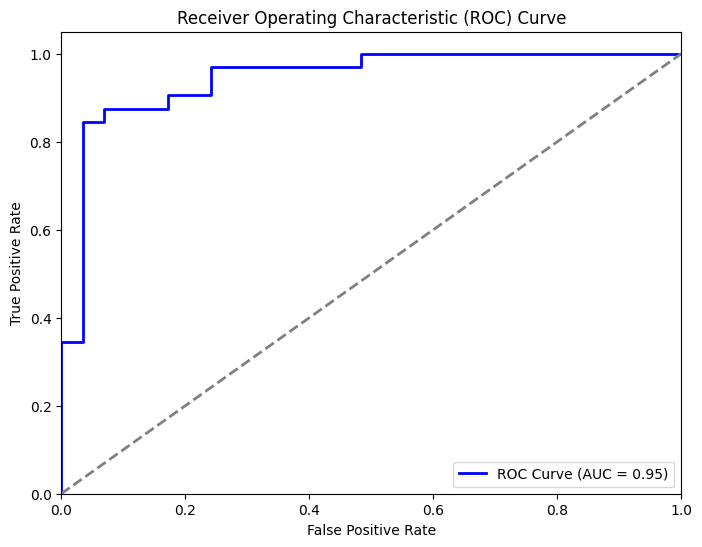

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = best_rf.predict(X_test)
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC-AUC Score: {roc_auc:.4f}')

# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [5]:
import ipywidgets as widgets
from IPython.display import display

# Create input widgets for the features
age = widgets.IntSlider(value=50, min=20, max=80, step=1, description='Age:')
sex = widgets.Dropdown(options=[('Male', 1), ('Female', 0)], description='Sex:')
cp = widgets.IntSlider(value=1, min=0, max=3, step=1, description='CP:')
trestbps = widgets.IntSlider(value=130, min=90, max=200, step=1, description='Trestbps:')
chol = widgets.IntSlider(value=200, min=100, max=400, step=1, description='Chol:')
fbs = widgets.ToggleButtons(options=[('True', 1), ('False', 0)], description='FBS > 120:')
restecg = widgets.IntSlider(value=0, min=0, max=2, step=1, description='RestECG:')
thalach = widgets.IntSlider(value=150, min=70, max=200, step=1, description='Thalach:')
exang = widgets.ToggleButtons(options=[('Yes', 1), ('No', 0)], description='Exang:')
oldpeak = widgets.FloatSlider(value=1.0, min=0.0, max=6.0, step=0.1, description='Oldpeak:')
slope = widgets.IntSlider(value=1, min=0, max=2, step=1, description='Slope:')
ca = widgets.IntSlider(value=0, min=0, max=3, step=1, description='CA:')
thal = widgets.IntSlider(value=2, min=0, max=3, step=1, description='Thal:')

# Display the widgets
display(age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal)

# Button for prediction
predict_button = widgets.Button(description="Predict")

# Output area
output = widgets.Output()

def predict_heart_disease(b):
    # Collect the inputs
    input_data = np.array([[age.value, sex.value, cp.value, trestbps.value, chol.value,
                            fbs.value, restecg.value, thalach.value, exang.value, oldpeak.value,
                            slope.value, ca.value, thal.value]])

    # Make a prediction
    prediction = best_rf.predict(input_data)
    probability = best_rf.predict_proba(input_data)

    # Display the results
    with output:
        output.clear_output()
        print(f"Prediction: {'Heart Disease' if prediction[0] == 1 else 'No Heart Disease'}")
        print(f"Probability: {probability[0][1]:.4f}")

# Bind the button to the prediction function
predict_button.on_click(predict_heart_disease)

# Display the button and output area
display(predict_button, output)


IntSlider(value=50, description='Age:', max=80, min=20)

Dropdown(description='Sex:', options=(('Male', 1), ('Female', 0)), value=1)

IntSlider(value=1, description='CP:', max=3)

IntSlider(value=130, description='Trestbps:', max=200, min=90)

IntSlider(value=200, description='Chol:', max=400, min=100)

ToggleButtons(description='FBS > 120:', options=(('True', 1), ('False', 0)), value=1)

IntSlider(value=0, description='RestECG:', max=2)

IntSlider(value=150, description='Thalach:', max=200, min=70)

ToggleButtons(description='Exang:', options=(('Yes', 1), ('No', 0)), value=1)

FloatSlider(value=1.0, description='Oldpeak:', max=6.0)

IntSlider(value=1, description='Slope:', max=2)

IntSlider(value=0, description='CA:', max=3)

IntSlider(value=2, description='Thal:', max=3)

Button(description='Predict', style=ButtonStyle())

Output()